In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from functools import reduce
from scipy.sparse import identity, kron, csr_matrix
from scipy.linalg import expm, eigh

In [50]:
# Create Hamiltonian as matrix as done in last sheet:

# Create csr Pauli matrices
id = identity(2, format='csr')
sigma_x = csr_matrix([[0, 1], [1, 0]], dtype=np.float64)
sigma_z = csr_matrix([[1, 0], [0, -1]], dtype=np.float64)

def kronecker(operators):
    # reduce calls the function (first arg) recursively on the list (second arg)
    return reduce(kron, operators)

def build_operator(operator, ind, L):
    # list of L identity operators
    operators = [id] * L

    # replace the ind-th operator with the given operator
    operators[ind] = operator

    # return the kronecker product of all identity matrices and the operator on site ind
    return csr_matrix(kronecker(operators))

def all_operators(operator, L):
    # a list of L operators, each one acting on a different site, otherwise identity
    return [build_operator(operator, j, L) for j in range(L)]

def Hamiltonian(h=1, J=1, L=4):
    # initialize matrices
    H = csr_matrix((2**L, 2**L), dtype=np.complex128)
    sz_list = all_operators(sigma_z, L)
    sx_list = all_operators(sigma_x, L)

    for i in range(L-1):
        H += -J*(sz_list[i] @ sz_list[i+1]) - h*(sx_list[i])
    return H

In [55]:
def energy_gap(L, h_max, steps):
    delta_Es = []

    for h in np.linspace(0, h_max, steps):
        H = Hamiltonian(h=h, J=1, L=L)

        # diagonalize the Hamiltonian
        e, v = eigh(H.toarray())
        
        delta_Es.append(np.abs(e[2] - e[0]))  # due to symmetry, this works

    return delta_Es

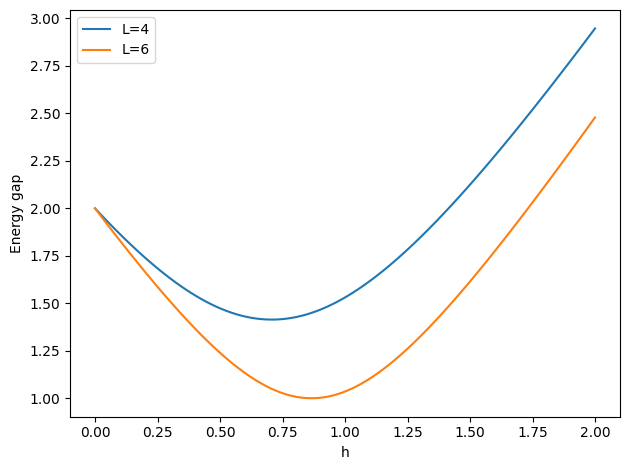

In [62]:
nsteps, h_max = 100, 2

delta_Es_L4 = energy_gap(L=4, h_max=h_max, steps=nsteps)
delta_Es_L6 = energy_gap(L=6, h_max=h_max, steps=nsteps)

fig, ax = plt.subplots()

ax.plot(np.linspace(0, h_max, nsteps), delta_Es_L4, label='L=4')
ax.plot(np.linspace(0, h_max, nsteps), delta_Es_L6, label='L=6')

ax.set_xlabel('h')
ax.set_ylabel('Energy gap')

ax.legend()

plt.tight_layout()

In [70]:
def wrap_hamiltonian(h, J, L):
    def wrapper(s):
        return Hamiltonian(h=h, J=J, L=L)
    return wrapper

In [104]:
def dpsi_dt(s, psi, H, L):
    psi = psi.view(dtype=np.complex128)
    return (-1j * H @ psi).view(dtype=np.float64)    

def dpsidt_wrapper(h, J, L):
    H_int = Hamiltonian(h, J, L)
    H0 = Hamiltonian(0, J, L)

    def wrapper(s, psi):
        H = (1 - s) * H0 + s * H_int
        return dpsi_dt(s, psi, H=H, L=L)
    
    return wrapper


In [151]:
h, J, L = 2, 1, 4

ground_state_psi = np.zeros(2**L, dtype=np.complex128)
ground_state_psi[0] = 1
psi0 = ground_state_psi

In [152]:
# integration
dpsidt = dpsidt_wrapper(h, J, L)
Nsteps = 10000

sol = solve_ivp(dpsidt, t_span = (0, 1), y0 = psi0.view(dtype=np.float64), t_eval=np.linspace(0, 1, Nsteps))
psi_tau_list = sol.y.T.copy().view(dtype=np.complex128)

In [153]:
exact_E0 = np.zeros(Nsteps)
adiabatic_E0 = np.zeros(Nsteps)
overlap = np.zeros(Nsteps)

for i, s in enumerate(np.linspace(0, 1, Nsteps)):
    # Get the Hamiltonian at time s
    H = (1 - s) * Hamiltonian(0, J, L) + s * Hamiltonian(h, J, L)
    
    # exact ground state energy at time s
    e, v = eigh(H.toarray())

    exact_E0[i] = e[0]

    # adiabatic ground state energy at time s
    adiabatic_E0[i] = np.real(psi_tau_list[i] @ H @ psi_tau_list[i].conjugate())

    # overlap between evolving psi and exact ground state
    overlap[i] = np.abs(psi_tau_list[i] @ v[:, np.argmin(e)].conjugate())

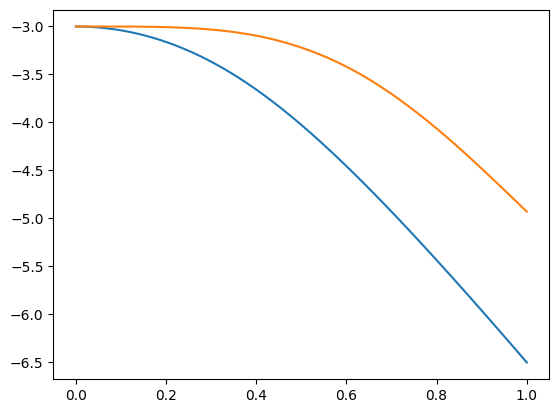

In [149]:
plt.plot(sol.t, exact_E0, label='Exact E0')
plt.plot(sol.t, adiabatic_E0, label='Adiabatic E0')

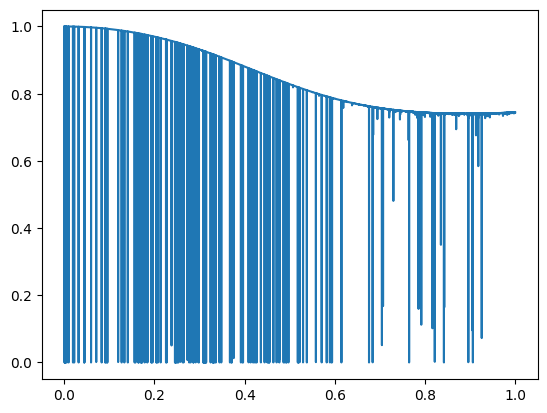

In [150]:
plt.plot(sol.t, overlap)

In [129]:
psi_tau_list.dtype, v.dtype

(dtype('complex128'), dtype('complex128'))